In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
data = pd.read_csv('btc-usd-max.csv', parse_dates = True)
data['Date'] = pd.to_datetime(data['Date']).dt.date
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
prices = pd.DataFrame(data['price'])
data = prices
print(data)

                    price
Date                     
2013-04-28     135.300000
2013-04-29     141.960000
2013-04-30     135.300000
2013-05-01     117.000000
2013-05-02     103.430000
...                   ...
2025-01-24  104067.609912
2025-01-25  104835.192536
2025-01-26  104796.040777
2025-01-27  102552.248743
2025-01-28  101958.469537

[4292 rows x 1 columns]


In [3]:
# Normalize the dataset (Scale values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for GRU
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)): 
        X.append(data[i-time_steps:i])
        y.append(data[i]) 
    return np.array(X), np.array(y)

# Define time step (how many previous days to consider)
time_steps = 360

# Create sequences
X, y = create_sequences(scaled_data, time_steps)

# Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")


Training shape: (3145, 360, 1), Testing shape: (787, 360, 1)


In [4]:
len(X)

3932

In [5]:
len(prices)

4292

In [6]:
X_test[-1]

array([[0.40619217],
       [0.40436574],
       [0.40080837],
       [0.40127105],
       [0.40541121],
       [0.4163393 ],
       [0.42661929],
       [0.44362897],
       [0.44952592],
       [0.45349227],
       [0.47102291],
       [0.46802624],
       [0.48742062],
       [0.48900439],
       [0.49096646],
       [0.48642498],
       [0.49070308],
       [0.48717696],
       [0.4921007 ],
       [0.48791619],
       [0.48298513],
       [0.47847661],
       [0.4851865 ],
       [0.48705983],
       [0.51275197],
       [0.5365502 ],
       [0.58889987],
       [0.57702246],
       [0.58765648],
       [0.58427548],
       [0.59356016],
       [0.64193756],
       [0.60523087],
       [0.62270618],
       [0.63023539],
       [0.64314952],
       [0.64496597],
       [0.65031551],
       [0.67910411],
       [0.67285256],
       [0.68821893],
       [0.67240831],
       [0.65429325],
       [0.61466198],
       [0.64418768],
       [0.63743579],
       [0.58488473],
       [0.638

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True,  # Restore best model weights
    verbose=1            # Print messages when stopping
)

In [9]:
# Define GRU model
model = Sequential([
    GRU(units=128, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(units=64, return_sequences=True, activation='tanh'),
    Dropout(0.2),
    GRU(units=64, return_sequences=False, activation='tanh'),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=1)  # Output layer predicting the future price
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Model summary
model.summary()


c:\Users\Piotr\Desktop\Studia\ML\ML_venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 360, 128)       │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 360, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 360, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 360, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,625 (447.75 KB)

 Trainable params: 114,625 (447.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0320 - val_loss: 0.1590
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 0.0179 - val_loss: 0.0741
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0099 - val_loss: 0.0260
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0050 - val_loss: 0.0095
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 0.0018 - val_loss: 8.5258e-04
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 0.0010 - val_loss: 8.4490e-04
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 9.7639e-04 - val_loss: 0.0011
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 8.8868e-04 - val_loss: 9.3524e-04
Epoch 10/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 7.2046e-04 - val_loss: 8.8034e-04
Epoch 11/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 7.7567e-04 - val_loss: 8.8673e-04
Epoch 12/15
13/13 ━━━━━━━━━━━━━━━━━━━━

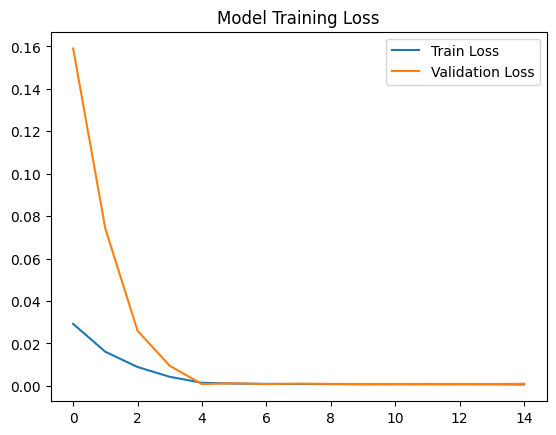

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=256, validation_data=(X_test, y_test), callbacks = [early_stopping], verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Loss')
plt.show()


In [11]:
# Tabel value of training loss & validation loss
learningrate_parameter = 0.0001
train_loss=history.history['loss'][-1]
validation_loss=history.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.000661,0.000977


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


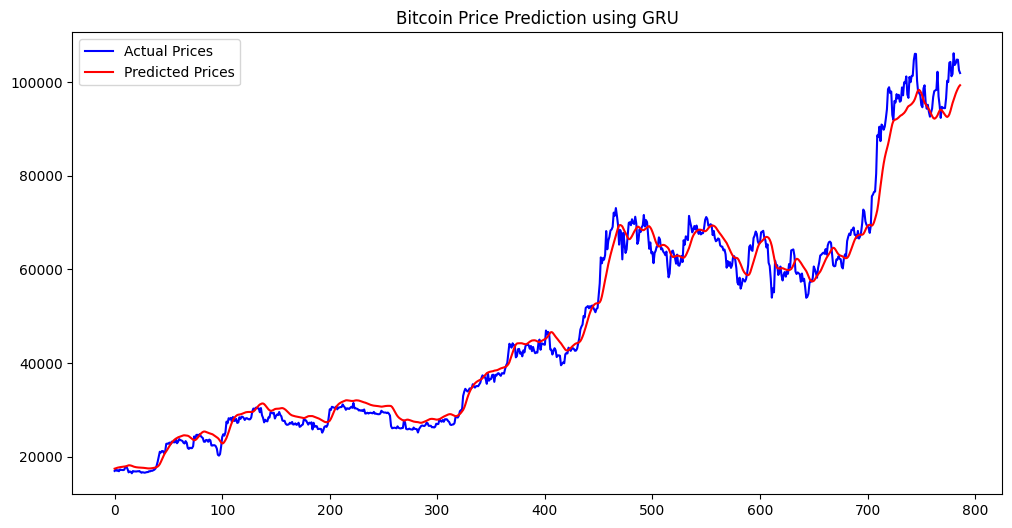

In [12]:
# Predict on test set
y_pred = model.predict(X_test)

# Reverse the scaling
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(y_pred_actual, label="Predicted Prices", color='red')
plt.legend()
plt.title("Bitcoin Price Prediction using GRU")
plt.show()


In [13]:
y_scaled = y_test.reshape(-1, 1)

# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Root Mean Square Error :',rmse(y_scaled, y_pred))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Mean Absolute Percentage Error : ', mape(y_scaled, y_pred), '%')

Root Mean Square Error : 0.0291
Mean Absolute Percentage Error :  4.7767 %


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

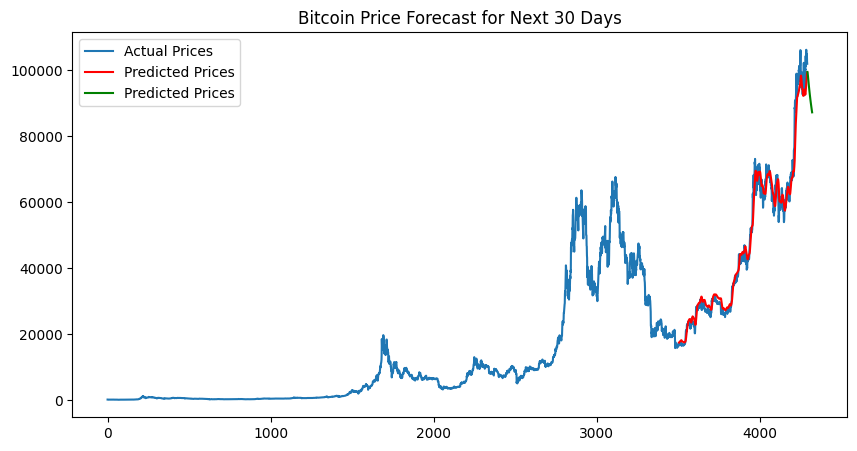

In [14]:
# Get the last 'time_steps' days of data
last_60_days = scaled_data[-time_steps:]    #360
predictions = []

# Predict the next 30 days
for _ in range(30):
    input_seq = last_60_days.reshape(1, time_steps, 1)
    next_price = model.predict(input_seq)[0, 0]
    
    predictions.append(next_price)  # Store the prediction
    
    # Update last_60_days (shift left and add new prediction)
    last_60_days = np.roll(last_60_days, -1)
    last_60_days[-1] = next_price

# Convert predictions back to actual prices
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot future predictions
plt.figure(figsize=(10, 5))
# plt.plot(predicted_prices, label="Predicted Future Prices", color='green')
plt.plot(range(len(prices)), prices, label="Actual Prices")
plt.plot(range(len(prices) - len(X_test), len(prices)), y_pred_actual, label="Predicted Prices", color='red')
plt.plot(range(len(prices), len(prices) + 30), predicted_prices, label="Predicted Prices", color = 'green')
plt.legend()
plt.title("Bitcoin Price Forecast for Next 30 Days")
plt.show()


In [15]:
# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Root Mean Square Error :',rmse(y_test_actual, y_pred_actual))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Mean Absolute Percentage Error : ', mape(y_test_actual, y_pred_actual), '%')

Root Mean Square Error : 3084.4437
Mean Absolute Percentage Error :  4.7676 %
